<a href="https://colab.research.google.com/github/Greta-gerasimov/PyT/blob/L10_Project/L10_1_gcm_PyT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install facenet-pytorch==2.5.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 19.9 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm

from glob import glob
import sys, os

from sklearn.model_selection import train_test_split

# import PIL
from PIL import Image
import matplotlib.pyplot as plt
# import cv2

import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!unzip /content/drive/MyDrive/ColabNotebooks/Project23/WEB_recog.zip

In [5]:
images = glob('leapGestRecog/**/**/*.png')

In [6]:
labels = [int(os.path.basename(img).split('_')[2])-1 for img in images]

images[:3], labels[:3], len(images), len(labels)

(['leapGestRecog/01/02_l/frame_01_02_0178.png',
  'leapGestRecog/01/02_l/frame_01_02_0131.png',
  'leapGestRecog/01/02_l/frame_01_02_0026.png'],
 [1, 1, 1],
 20000,
 20000)

In [7]:
num_name_list = [(int((os.path.split(img)[0].split('/')[-1].split('_'))[0])-1, os.path.split(img)[0].split('/')[-1].split('_')[1:]) for img in images]
num_name_dict = {}
for num, name in num_name_list:
    if num not in num_name_dict.keys():
        num_name_dict[num] = name

sorted(num_name_dict.items(), key = lambda x: x[0])

[(0, ['palm']),
 (1, ['l']),
 (2, ['fist']),
 (3, ['fist', 'moved']),
 (4, ['thumb']),
 (5, ['index']),
 (6, ['ok']),
 (7, ['palm', 'moved']),
 (8, ['c']),
 (9, ['down'])]

In [8]:
def num_to_classname(num):

    if num == 0:
        return 'palm'
    elif num == 1:
        return 'l'
    elif num == 2:
        return 'fist'
    elif num == 3:
        return 'fist_moved'
    elif num == 4:
        return 'thumb'
    elif num == 5:
        return 'index'
    elif num == 6:
        return 'ok'
    elif num == 7:
        return 'palm_moved'
    elif num == 8:
        return 'c'
    elif num == 9:
        return 'down'

In [9]:
# Train test split

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.25, random_state=42)

(240, 640)


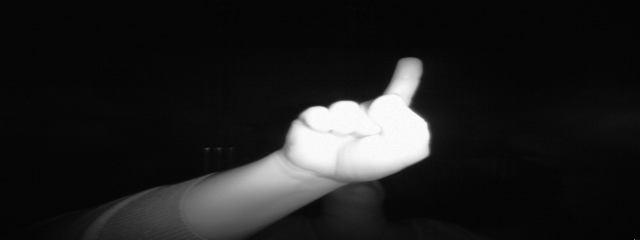

In [10]:
img = Image.open(images[4563])
print(np.array(img).shape)
img

In [11]:
# Transform train & test data

train_tfms = transforms.Compose([
                         transforms.Grayscale(num_output_channels=1), # Картинки черно-белые - переводим чтобы была 1-канальность1
                         transforms.Resize((48,48)),
                         transforms.RandomHorizontalFlip(), # Случайные повороты на 90 градусов
                         transforms.RandomRotation(30), # Случайные повороты на 30 градусов
                         transforms.ToTensor()]) # Приведение к тензору
                         # это на обучение чтобы сделать побольше данный и аугмиентацию

test_tfms =  transforms.Compose([
                         transforms.Grayscale(num_output_channels=1),
                         transforms.Resize((48,48)),
                         transforms.ToTensor()])
                         # а для теста тольуо перевод в чб и в тензор переводим

In [12]:
class GestRecogDataset(Dataset):
    def __init__(self, images_gestures, labels, transformer):
        self.images = images_gestures
        self.labels = labels
        self.transformer = transformer

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img =  Image.open(self.images[idx])
        img = self.transformer(img)

        return img, self.labels[idx]

In [13]:
batch_size = 256

# Create datasets
train_dataset = GestRecogDataset(X_train, y_train, train_tfms)
test_dataset = GestRecogDataset(X_test, y_test, test_tfms)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size, shuffle = True, drop_last = True)
test_loader = DataLoader(test_dataset, batch_size, shuffle = False)

Класс: 0 - palm
torch.Size([1, 48, 48])


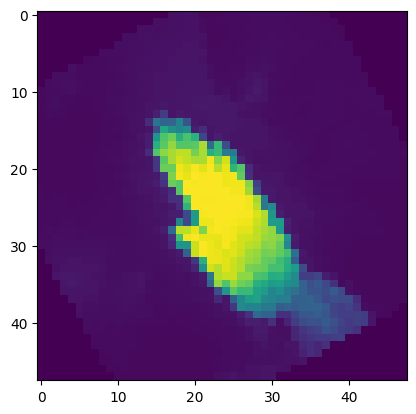

Класс: 1 - l
torch.Size([1, 48, 48])


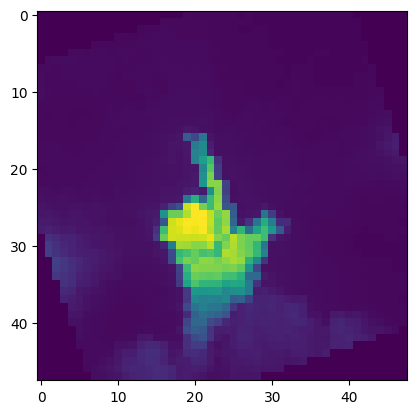

Класс: 5 - index
torch.Size([1, 48, 48])


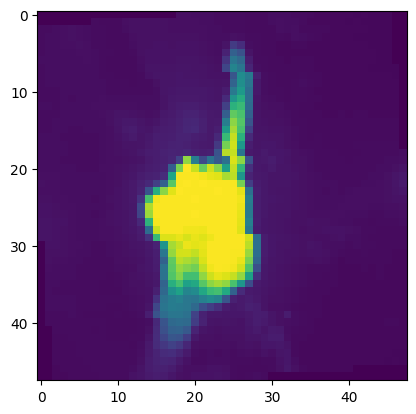

In [14]:
for i, data in enumerate(train_loader):
    print(f'Класс: {data[1][i]} - {num_to_classname(data[1][i])}')
    print(data[0][i].shape)
    plt.imshow(data[0][i].permute(1,2,0).squeeze())
    plt.show()
    if i==2:
        break

image: torch.Size([1, 48, 48])


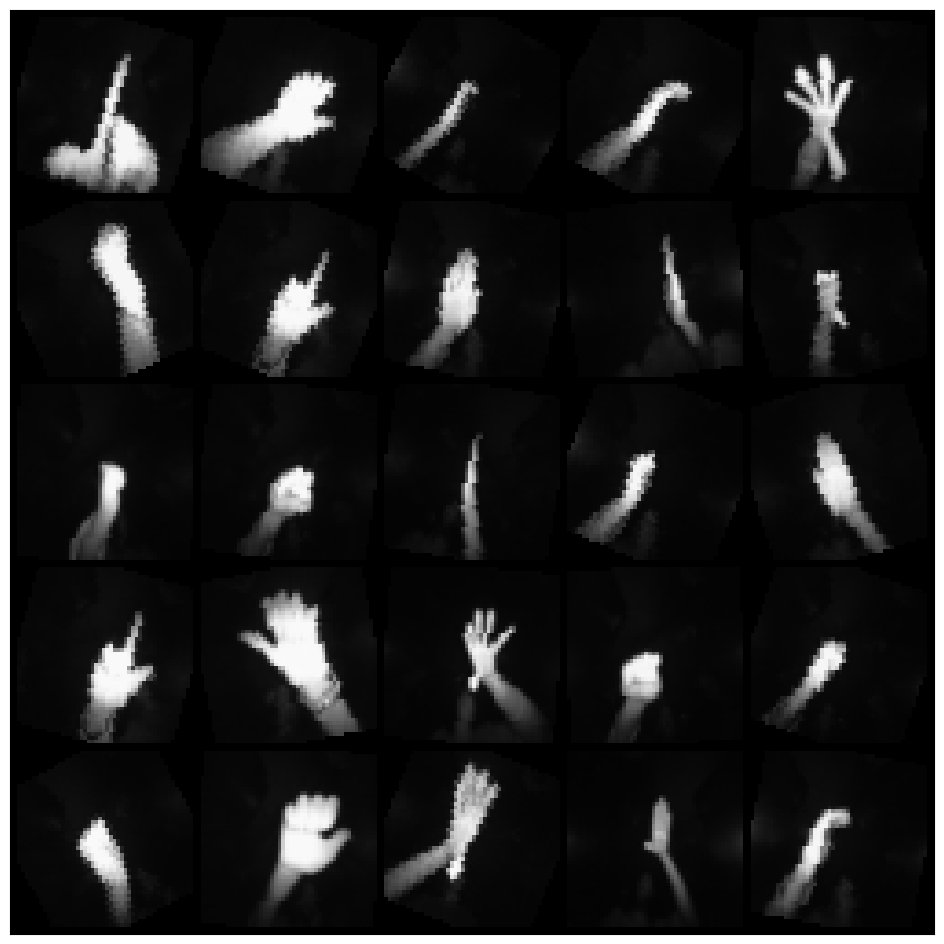

In [15]:
def show_batch(train_loader):

    for images, labels in train_loader:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(f'image: {images[0].shape}')
        ax.imshow(make_grid(images[:25], nrow=5).permute(1, 2, 0))
        break

show_batch(train_loader)

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [17]:
# Class ResNet

def conv_block(in_channels, out_channels, pool=False):

    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ELU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(2))

    return nn.Sequential(*layers)

def linear_block(input_dim, output_dim, activation = False, dropout = 0.3):

    layers = [nn.Linear(input_dim, output_dim),
             nn.Dropout(dropout)]
    if activation:
        layers.append(nn.ReLU())

    return nn.Sequential(*layers)

class ResNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 128)
        self.conv2 = conv_block(128, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        self.drop1 = nn.Dropout(0.5)

        self.conv3 = conv_block(128, 256)
        self.conv4 = conv_block(256, 256, pool=True)
        self.res2 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))
        self.drop2 = nn.Dropout(0.5)

        self.conv5 = conv_block(256, 512)
        self.conv6 = conv_block(512, 512, pool=True)
        self.res3 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        self.drop3 = nn.Dropout(0.5)

        self.classifier = nn.Sequential(nn.MaxPool2d(6),
                                        nn.Flatten(),
                                        nn.Linear(512, num_classes))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.drop1(out)

        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.drop2(out)

        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out) + out
        out = self.drop3(out)

        out = self.classifier(out)
        return out

In [18]:
model = ResNet(1, len(num_name_dict)).to(device)

In [19]:
model

ResNet(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [20]:
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), learning_rate)
criterion = nn.CrossEntropyLoss()

Real gesture: (3, 'fist_moved'), Predicted gesture: (8, 'c')


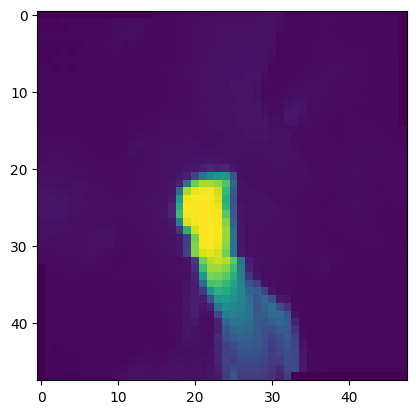

In [21]:
for i, (img, label) in enumerate(train_loader):
    output = model(img[i][None].to(device))
    print(f'Real gesture: {int(label[i]), num_to_classname(int(label[i]))}, '
          f'Predicted gesture: {int(output.argmax(1)), num_to_classname(int(output.argmax(1)))}')
    plt.imshow(img[i].permute(1,2,0).squeeze())
    break

In [22]:
epochs = 10

epoch_losses = []

for epoch in range(epochs):

    train_running_loss = 0.0
    total_acc_train = 0.0
    epoch_loss = []
    for data, labels in tqdm(train_loader):
        data = data.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(data)
        loss = criterion(outputs, labels)

        train_running_loss += loss.item()
        epoch_loss.append(loss.item())

        acc = (outputs.argmax(dim=1) == labels).sum().item()
        total_acc_train += acc

        loss.backward()
        optimizer.step()


    test_running_loss, total_acc_test = 0.0, 0.0
    test_epoch_loss = []
    for data, labels in test_loader:
        model.eval()
        data = data.to(device)
        labels = labels.to(device)

        outputs = model(data)
        loss = criterion(outputs, labels)

        test_running_loss += loss.item()
        test_epoch_loss.append(loss.item())

        acc = (outputs.argmax(dim=1) == labels).sum().item()
        total_acc_test += acc

    print(f'Epoch {epoch+1}, loss:, {np.mean(epoch_loss)}, Train acc:, {total_acc_train / len(train_dataset):.3f}  '
          f'Test loss:, {np.mean(test_epoch_loss)}, Test acc: {total_acc_test / len(test_dataset):.3f}')
    epoch_losses.append(epoch_loss)

100%|██████████| 58/58 [00:53<00:00,  1.08it/s]


Epoch 1, loss:, 5.575221267239801, Train acc:, 0.140  Test loss:, 16.886286163330077, Test acc: 0.205


100%|██████████| 58/58 [00:42<00:00,  1.38it/s]


Epoch 2, loss:, 2.6751453424322196, Train acc:, 0.112  Test loss:, 2.294779026508331, Test acc: 0.172


100%|██████████| 58/58 [00:43<00:00,  1.33it/s]


Epoch 3, loss:, 2.2429787454933954, Train acc:, 0.157  Test loss:, 2.1340049505233765, Test acc: 0.184


100%|██████████| 58/58 [00:42<00:00,  1.36it/s]


Epoch 4, loss:, 1.9920138182311222, Train acc:, 0.242  Test loss:, 1.882889884710312, Test acc: 0.302


100%|██████████| 58/58 [00:42<00:00,  1.37it/s]


Epoch 5, loss:, 1.7632942466900265, Train acc:, 0.349  Test loss:, 1.469151932001114, Test acc: 0.522


100%|██████████| 58/58 [00:42<00:00,  1.37it/s]


Epoch 6, loss:, 1.5728932290241635, Train acc:, 0.445  Test loss:, 1.0742596745491029, Test acc: 0.638


100%|██████████| 58/58 [00:42<00:00,  1.35it/s]


Epoch 7, loss:, 1.0347801056401482, Train acc:, 0.616  Test loss:, 0.6564733207225799, Test acc: 0.782


100%|██████████| 58/58 [00:42<00:00,  1.37it/s]


Epoch 8, loss:, 0.7392053126261152, Train acc:, 0.717  Test loss:, 0.6108472943305969, Test acc: 0.754


100%|██████████| 58/58 [00:41<00:00,  1.38it/s]


Epoch 9, loss:, 0.5332324247935722, Train acc:, 0.797  Test loss:, 0.3366533800959587, Test acc: 0.864


100%|██████████| 58/58 [00:41<00:00,  1.40it/s]


Epoch 10, loss:, 0.3520267950049762, Train acc:, 0.866  Test loss:, 0.2520017474889755, Test acc: 0.898


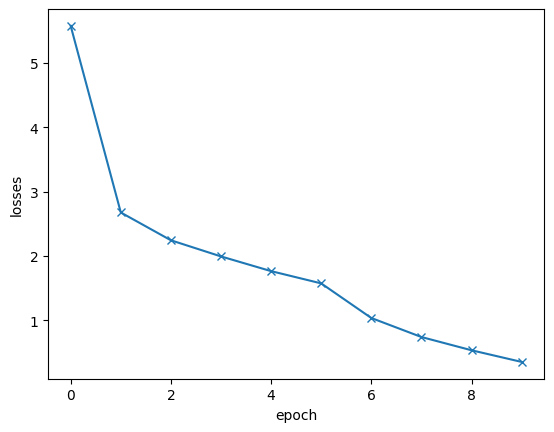

In [23]:
# Plot loss

losses = [np.mean(loss) for loss in epoch_losses]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('losses');

In [24]:
# Save model

model_path = './gesture_classification_model.pth'
torch.save(model, model_path)

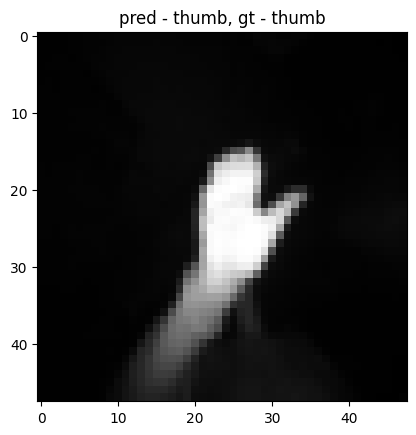

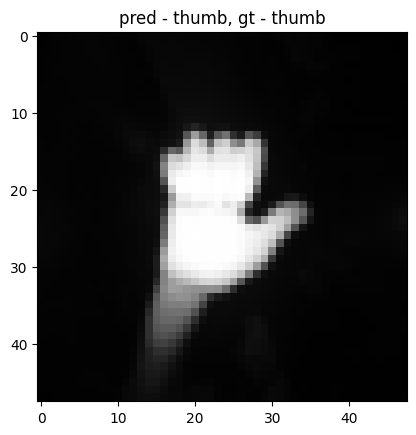

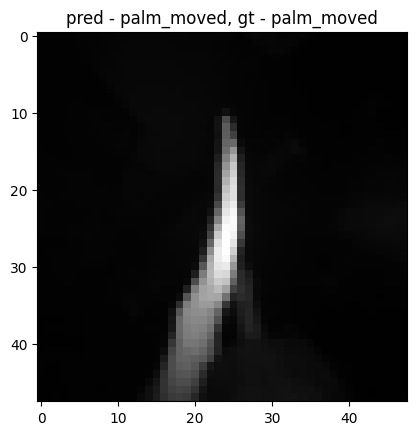

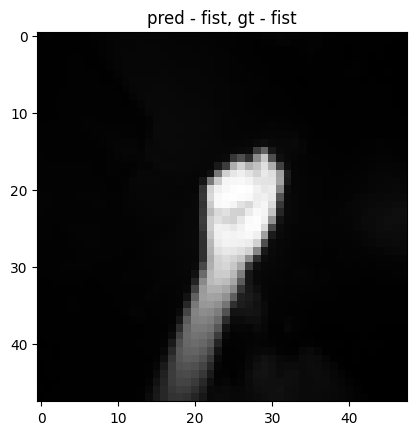

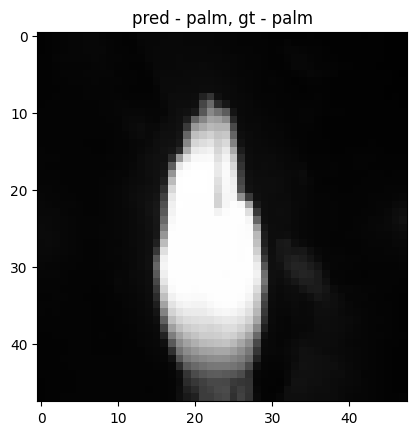

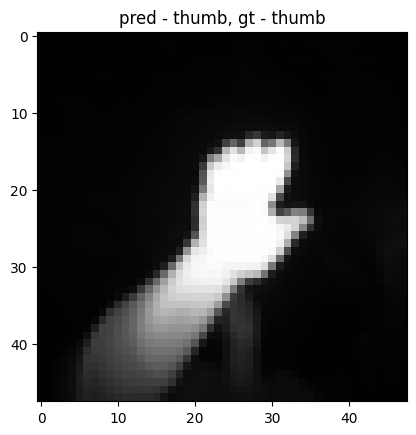

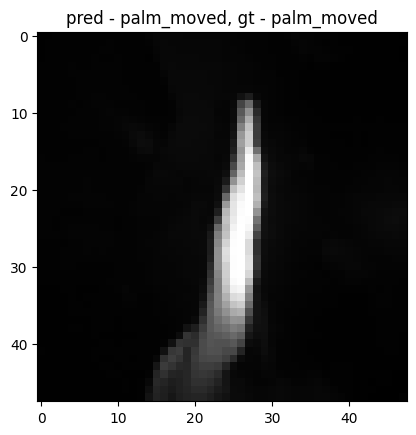

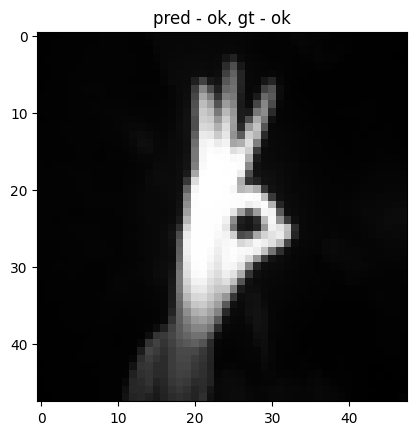

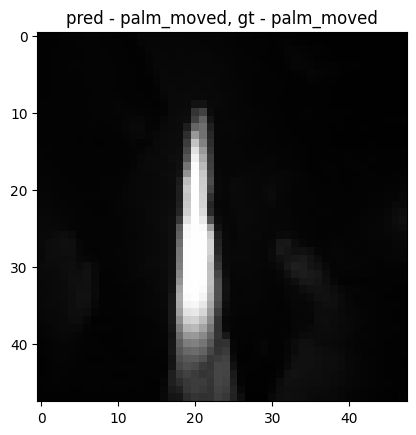

In [25]:
# Load model

model = torch.load(model_path)
with torch.no_grad():
    for i, data in enumerate(test_loader, 3):
        images, labels = data[0].to(device), data[1].to(device)

        outputs = model(images)
        plt.title(f'pred - {num_to_classname(outputs[0].argmax())}, gt - {num_to_classname(labels[0])}')
        plt.imshow(images[0].cpu().squeeze(), cmap='gray')
        plt.show()
        if i>10:
            break

##**Test**##


In [26]:
!pip install facenet_pytorch

In [27]:
import numpy as np
import pandas as pd
from tqdm import tqdm

from glob import glob
import sys, os

from sklearn.model_selection import train_test_split

# import PIL
from PIL import Image
import matplotlib.pyplot as plt
import cv2

import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid

from facenet_pytorch import MTCNN

In [28]:
# Class ResNet

def conv_block(in_channels, out_channels, pool=False):

    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ELU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(2))

    return nn.Sequential(*layers)

def linear_block(input_dim, output_dim, activation = False, dropout = 0.3):

    layers = [nn.Linear(input_dim, output_dim),
             nn.Dropout(dropout)]
    if activation:
        layers.append(nn.ReLU())

    return nn.Sequential(*layers)

class ResNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 128)
        self.conv2 = conv_block(128, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        self.drop1 = nn.Dropout(0.5)

        self.conv3 = conv_block(128, 256)
        self.conv4 = conv_block(256, 256, pool=True)
        self.res2 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))
        self.drop2 = nn.Dropout(0.5)

        self.conv5 = conv_block(256, 512)
        self.conv6 = conv_block(512, 512, pool=True)
        self.res3 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        self.drop3 = nn.Dropout(0.5)

        self.classifier = nn.Sequential(nn.MaxPool2d(6),
                                        nn.Flatten(),
                                        nn.Linear(512, num_classes))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.drop1(out)

        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.drop2(out)

        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out) + out
        out = self.drop3(out)

        out = self.classifier(out)
        return out

In [29]:
# Загружаю модель, cозданную выше

gest_model = torch.load(model_path, map_location='cpu')
gest_model.eval()

ResNet(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [36]:
images = glob('leapGestRecog/**/**/*.png')

In [37]:
labels = [int(os.path.basename(img).split('_')[2])-1 for img in images]

images[:3], labels[:3], len(images), len(labels)

(['leapGestRecog/01/02_l/frame_01_02_0178.png',
  'leapGestRecog/01/02_l/frame_01_02_0131.png',
  'leapGestRecog/01/02_l/frame_01_02_0026.png'],
 [1, 1, 1],
 20000,
 20000)

In [38]:
num_name_list = [(int((os.path.split(img)[0].split('/')[-1].split('_'))[0])-1, os.path.split(img)[0].split('/')[-1].split('_')[1:]) for img in images]
num_name_dict = {}
for num, name in num_name_list:
    if num not in num_name_dict.keys():
        num_name_dict[num] = name

sorted(num_name_dict.items(), key = lambda x: x[0])

[(0, ['palm']),
 (1, ['l']),
 (2, ['fist']),
 (3, ['fist', 'moved']),
 (4, ['thumb']),
 (5, ['index']),
 (6, ['ok']),
 (7, ['palm', 'moved']),
 (8, ['c']),
 (9, ['down'])]

In [39]:
def num_to_classname(num):

    if num == 0:
        return 'palm'
    elif num == 1:
        return 'l'
    elif num == 2:
        return 'fist'
    elif num == 3:
        return 'fist_moved'
    elif num == 4:
        return 'thumb'
    elif num == 5:
        return 'index'
    elif num == 6:
        return 'ok'
    elif num == 7:
        return 'palm_moved'
    elif num == 8:
        return 'c'
    elif num == 9:
        return 'down'

In [40]:
# Train test split

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.25, random_state=42)

In [41]:
test_tfms =  transforms.Compose([
                         transforms.Grayscale(num_output_channels=1),
                         transforms.Resize((48,48)),
                         transforms.ToTensor()])
                         # а для теста тольуо перевод в чб и в тензор переводим

In [42]:
class GestRecogDataset(Dataset):
    def __init__(self, images_gestures, labels, transformer):
        self.images = images_gestures
        self.labels = labels
        self.transformer = transformer

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img =  Image.open(self.images[idx])
        img = self.transformer(img)

        return img, self.labels[idx]

In [43]:
batch_size = 256

# Create datasets
# train_dataset = GestRecogDataset(X_train, y_train, train_tfms)
test_dataset = GestRecogDataset(X_test, y_test, test_tfms)

# Create dataloaders
# train_loader = DataLoader(train_dataset, batch_size, shuffle = True, drop_last = True)
test_loader = DataLoader(test_dataset, batch_size, shuffle = False)

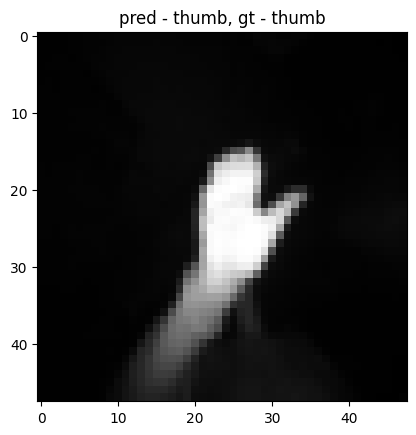

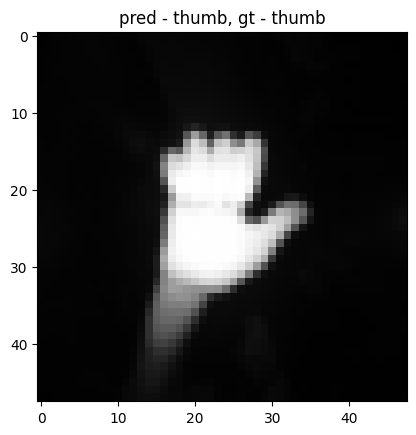

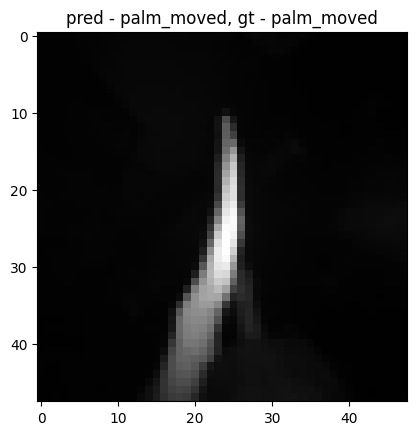

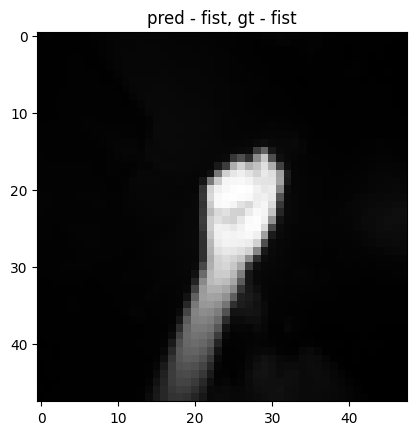

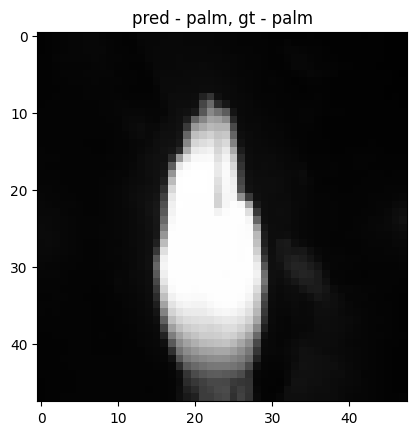

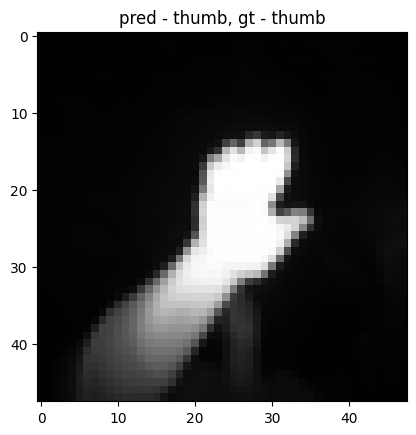

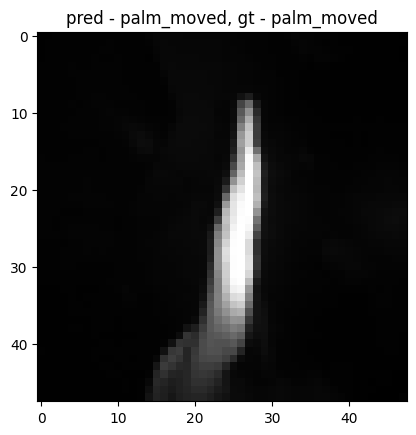

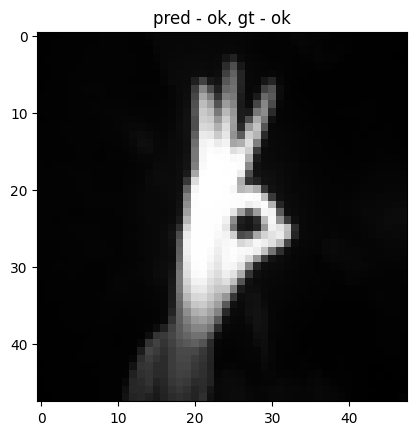

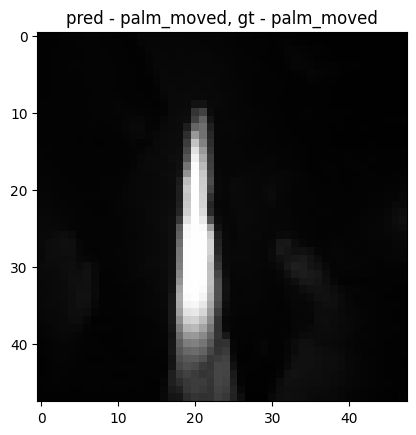

In [44]:
with torch.no_grad():
    for i, data in enumerate(test_loader, 3):
        images, labels = data[0].to('cpu'), data[1].to('cpu')

        outputs = gest_model(images)
        plt.title(f'pred - {num_to_classname(outputs[0].argmax())}, gt - {num_to_classname(labels[0])}')
        plt.imshow(images[0].cpu().squeeze(), cmap='gray')
        plt.show()
        if i>10:
            break

неудачная  проверить на тесте со своими картинками



In [45]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)



  return filename

<IPython.core.display.Javascript object>

Saved to foto1.jpg


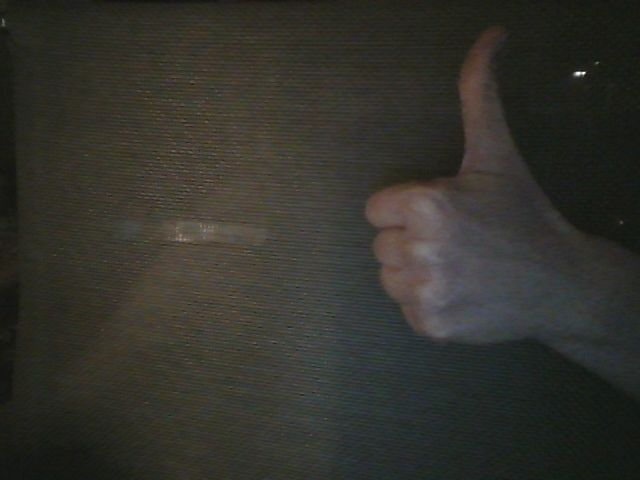

In [46]:
from IPython.display import Image
try:
  filename = take_photo('foto1.jpg')
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [48]:
import sys
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# параметры цветового фильтра
hsv_min = np.array((2, 28, 65), np.uint8)
hsv_max = np.array((26, 238, 255), np.uint8)

if __name__ == '__main__':
    print(__doc__)

    fn = 'photo1.jpg' # путь к файлу с картинкой
    img = cv2.imread(fn)

    imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ret, thresh = cv2.threshold(imgray, 30, 255, cv2.THRESH_BINARY)
# визуализировать двоичное изображение
    cv2_imshow(thresh)
    cv2.waitKey(0)
    cv2.imwrite('image_thresh1.jpg', thresh)
    cv2.destroyAllWindows()


Automatically created module for IPython interactive environment


error: ignored

In [66]:
gest = {'img': ['image_thres1.jpg', 'image_thres2.jpg', 'image_thres3.jpg', 'image_thres4.jpg'],
        'path': ['/content/image_thres1.jpg', '/content/image_thres2.jpg', '/content/image_thres3.jpg', '/content/image_thres4.jpg'],
        'gest': [9, 5, 6, 8]}
df = pd.DataFrame(gest)
df

,img,path,gest
0,image_thres1.jpg,/content/image_thres1.jpg,9
1,image_thres2.jpg,/content/image_thres2.jpg,5
2,image_thres3.jpg,/content/image_thres3.jpg,6
3,image_thres4.jpg,/content/image_thres4.jpg,8


In [67]:
class GestRecogDataset(torch.utils.data.Dataset):
    def __init__(self, data, preprocessing=None):
        self.data = data
        self.preprocessing = preprocessing

        self.image_paths = self.data.iloc[:, 1]
        self.image_gest = self.data.iloc[:, 2]
        self.data_len = len(self.data.index)

    def __len__(self):
        return self.data_len

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path)

        if self.preprocessing is not None:
            img = self.preprocessing(img)

        gest = self.image_gest[idx]

        return img, gest
test_dataset = GestRecogDataset(df)

In [68]:
test_loader = torch.utils.data.DataLoader(test_dataset,
                          batch_size=1,
                          shuffle=False,
                          num_workers=1)

In [69]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [70]:
dl = DeviceDataLoader(test_loader, device)

In [71]:
from pathlib import Path
from torchvision.datasets import ImageFolder

DATA_ROOT = Path('/content/leapGestRecog')

In [64]:
tmp_ds = ImageFolder(DATA_ROOT / '00')
CLASSES_NAME = tmp_ds.classes
CLASSES_NAME

['01_palm',
 '02_l',
 '03_fist',
 '04_fist_moved',
 '05_thumb',
 '06_index',
 '07_ok',
 '08_palm_moved',
 '09_c',
 '10_down']

In [73]:
from PIL import Image

with torch.no_grad():
    for i, data in enumerate(dl):
        images, labels = data[0].to(device), data[1].to(device)

        outputs = ResNet(images)
        plt.title(f'pred - {CLASSES_NAME[outputs[0].argmax()]}, gt - {CLASSES_NAME[labels[0]]}')
        plt.imshow(images[0].cpu().permute(1, 2, 0), cmap='gray')
        plt.show()
        if i>5:
            break

TypeError: ignored